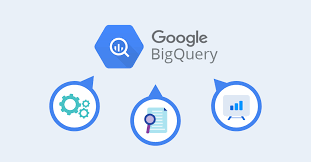

This notebook was creted to upload data from csv file, which was a resulting file from a previous ETL process to a Google Big Query data base table. After creating the table and passing the data to it, the program makes a SQL request to the recently created table and reads the data into a Pandas data frame.  The resulting table uploaded to Big Query will also later be connected to Looker Studio for the creation of different reports and dashboards



In [30]:
#importing neccesary modules
from pathlib import Path
import time
from google.cloud import bigquery
from google.oauth2 import service_account
import os


In [31]:
#Defining the function to uploaa data from a csv file to a Big Query data base table

def upload_csv(client, table_ref,csv_file):
    client.delete_table(table_ref, not_found_ok=True)
    load_job_configuration=bigquery.LoadJobConfig()
    load_job_configuration.schema=[
        bigquery.SchemaField('destination_warehouse', 'STRING', mode='NULLABLE'),
        bigquery.SchemaField('po_number', 'STRING', mode='NULLABLE'),
        bigquery.SchemaField('expected_date', 'DATE', mode='NULLABLE'),
        bigquery.SchemaField('received_at', 'DATE', mode='NULLABLE'),
        bigquery.SchemaField('po_quantity', 'INTEGER', mode='NULLABLE'),
        bigquery.SchemaField('sku', 'STRING', mode='NULLABLE'),
        bigquery.SchemaField('supplier_name', 'STRING', mode='NULLABLE'),
        bigquery.SchemaField('status', 'STRING', mode='NULLABLE'),
        bigquery.SchemaField('CBM', 'NUMERIC', mode='NULLABLE'),
        bigquery.SchemaField('completed_at', 'DATE', mode='NULLABLE'),
        bigquery.SchemaField('total_cbm', 'NUMERIC', mode='NULLABLE'),
        bigquery.SchemaField('reference_number', 'STRING', mode='NULLABLE'),


]



    load_job_configuration.source_format=bigquery.SourceFormat.CSV
    load_job_configuration.skip_leading_rows=1
    load_job_configuration.allow_quoted_newlines=True

    with open(csv_file,"rb") as source_file:
        upload_job=client.load_table_from_file(
            source_file,
            destination=table_ref,
            location="US",
            job_config=load_job_configuration
            )

    while upload_job.state !='DONE':
        time.sleep(20)
        upload_job.reload()
        print(upload_job.state)
        print(upload_job.result( ))



In [32]:
#defining Big Query table reference
def table_reference(project_id,dataset_id,table_id):
    dataset_ref=bigquery.DatasetReference(project_id, dataset_id)
    table_ref=bigquery.TableReference(dataset_ref,table_id)
    return table_ref

In [33]:
#Connecting To Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
#Big Query Connection parameters
%cd /content/drive/MyDrive/Big Query connection parameters
with open('project_id_big_query.txt', 'r') as file:
    project_id = file.read().strip()
with open('data_set_id_big_query.txt', 'r') as file:
    dataset_id = file.read().strip()
table_name='completed_pos_cbm_total_by_po_sku_warehouse'


/content/drive/MyDrive/Big Query connection parameters


In [38]:
#Define credentials reading from json service account file and connecting to Big Query Client
credentials =service_account.Credentials.from_service_account_file(
'vigilant-sunup-366016-e7742e2fb543.json')
client = bigquery.Client(credentials=credentials)

In [36]:
# read csv data that is going to be uploade to Big Query
csv_file=(r'completed_pos_cbm_total_by_po_sku_warehouse.csv')

In [39]:
#define table and make final uplaoding of csv data to table in Big query---Done message shows if uploding finished correctly
table_ref=table_reference(project_id,dataset_id,table_name)
upload_csv(client,table_ref,csv_file)

DONE
LoadJob<project=vigilant-sunup-366016, location=US, id=3600ac3f-b258-43b3-87e3-94bcb709c0f7>


In [40]:
#instal pandas google-cloud-bigquery module
!pip install google-cloud-bigquery pandas

In [41]:
# defining the table, data set and project
table_id = f"{project_id}.{dataset_id}.{table_name}"

In [44]:
#reading data directly into a pandas DF
df = client.query(f"SELECT destination_warehouse, po_number, sku, status FROM `{table_id}`").to_dataframe()

In [45]:
print(df)

               destination_warehouse po_number    sku     status
0                 Honolulu Warehouse   PO-1929   0514  completed
1                 Eastvale Warehouse   PO-1753   0149  completed
2                 Eastvale Warehouse   PO-1666   0075  completed
3                 Eastvale Warehouse   PO-1666   0145  completed
4                 Eastvale Warehouse   PO-1666  00109  completed
...                              ...       ...    ...        ...
14953  Eastvale CFP (Only CFP Parts)   PO-1757    F9B  completed
14954  Eastvale CFP (Only CFP Parts)   PO-1757    F5B  completed
14955  Eastvale CFP (Only CFP Parts)   PO-1757    F3B  completed
14956  Eastvale CFP (Only CFP Parts)   PO-1757   F11B  completed
14957  Eastvale CFP (Only CFP Parts)   PO-1757    F4B  completed

[14958 rows x 4 columns]
